In [1]:
# This tutorial will briefly show the main components of the aerodynamic reduced order model.
# We will create the database, create the physical model, and finally use them to plot the training signal
# that has been used, and the corresponding lift coefficient obtained.
# We will also plot the main PODs of the surface flow to understand how to manipulate the main data.
# After the completion of this tutorial you should be able to manipulate the training data to extract and
# plot quantities of interest.
# The test case is the first case of the aeroelastic prediction workshop. Thus, we have the BSCW with a Mach
# number of 0.74

In [2]:
# First, we perform the aerodynamic simulation with SU2. Please refer to the tutorial at 
# https://su2code.github.io/tutorials/Dynamic_FSI_Python/ for more details.

In [3]:
# Assuming that we correctly configured the SU2 simulation, we now have this list of output files:
# 1) The StructHistoryModal.dat file, containing the structural inputs that we provided to the system
# 2) A set of surface_flow.csv files, containing the aerodynamic solution at each time step of the training process

In [4]:
# Second, we launch again the same aerodynamic simulation, this time including the keyword "MAPPING_MODES = YES" in
# solid.cfg file. This will not actually run the simulation, but only print the normals and the modal shapes.

In [5]:
# If everything was correctly configured, we now have these files:
# 1) A file called Normals.csv, containing the normal to all the surface cells. Please note that the norm of these normals
# correspond to the area of the cell
# 2) A file called Undeformed.csv, containing the position of the cells in the undeformed configuration
# 3) A se of files called Mode.csv, containing the positions of the cells for the different modal shapes

In [6]:
# We are now ready to build our database.

# import the aerodynamic module
import os
os.chdir("..")
import aerodynamics
os.chdir("Tutorials")

# location of the structural history file
stru_history = "data/blendedStep/StructHistoryModal.dat"

# location of the aerodynamic history files
aero_history = "data/blendedStep/surface_flow.csv"
# note that all the files are called surface_flow_00xxx.csv, with xxx the time iteration
# it is sufficient to put the main name, the code will then scan for the requested time iterations

In [7]:
# creation of the database
database = aerodynamics.database(stru_history,aero_history)



Creating the database for the reduced order model.
Importing the data from the files.
Opened structural history file data/blendedStep/StructHistoryModal.dat.
Completed reading
Starting the reading of surface_flow.csv files.
Opened time iter 1099 last time iter is 1099
Completed reading
Done


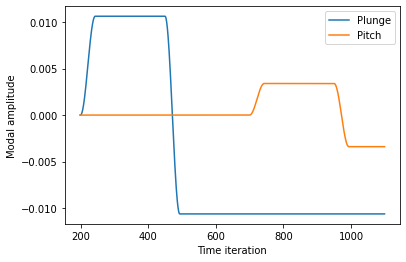

<Figure size 432x288 with 0 Axes>

In [8]:
# plot of the training signals, per each mode
import matplotlib.pyplot as plt
nModes = database.U.shape[0]
for i in range(nModes):
    ax = plt.plot(database.timeIter, database.U[i,:]) # Each row is a different mode, each column a time iteration

# just make the plot pretty
plt.xlabel("Time iteration")
plt.ylabel("Modal amplitude")
plt.legend(["Plunge","Pitch"])
plt.show()
plt.savefig('exampleTrainingSingal.eps', format='eps')


In [9]:
# We now want to plot the lift obtained with these inputs
# In order to do so we need a physical model of the system, to connect
# the database, containing a list of pressure values, with the application
# points of these pressures, and the direction of application to the surface
model = aerodynamics.physicalModel("data/Modes/Normals.csv","data/Modes/Mode.csv")
# Note that again we have more mode files, Mode0.csv, Mode1.csv, ecc... so we only give the main name

Creating the physical model.
Importing the data from the files.
Obtaining the normals to the different panels.
Completed reading
Obtaining the mode shapes
Starting with the undeformed condition
Obtain now the deformation due to modes
Opened file 1 of 2
Opened file 2 of 2
Completed reading
Done


Text(0, 0.5, 'Lift [N]')

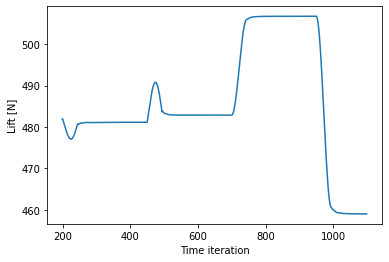

In [10]:
import numpy as np
# plot of the lift
nTimeIter = database.X.shape[1]
lift = []
for i in range(nTimeIter):
    lift = np.append(lift, model.getCl(database.X[:,i]))

plt.plot(database.timeIter, lift)
# just make the plot pretty
plt.xlabel("Time iteration")
plt.ylabel("Lift [N]")


In [11]:
# We will now perform the SVD of the aerodynamic state
# This function gives back several outputs, but they will analysed with more detail in a later tutorial. Also the only
# input provided to this function will later be analysed with more detail. It is related to a stabilisation procedure.
Up, Sp, VTp, Xcenter, U, S, VT, slope, stateToSubtract = database.getSVD(False)

In [12]:
# The code will automatically apply an optimal threshold to cut the dimension of the matrices, remeber we have 900 snapshots
# so the full dimension is 86840, 900
Up.shape

(86840, 414)

Text(0.5, 0, 'Index')

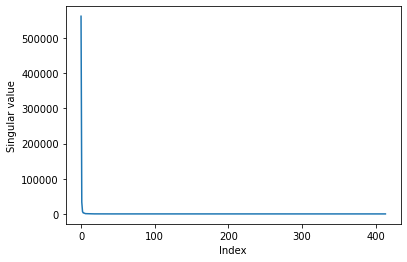

In [13]:
# In order to check the singular values we can plot them
plt.plot(np.diag(Sp))
plt.ylabel("Singular value")
plt.xlabel("Index")

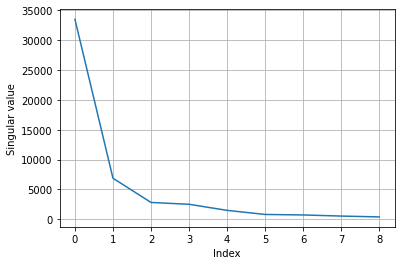

In [14]:
# They actually decrease extremely rapidly. If we focus on the first indices
plt.plot(np.diag(Sp)[1:10])
plt.ylabel("Singular value")
plt.xlabel("Index")
plt.grid()
plt.savefig('singularValues.eps', format='eps')

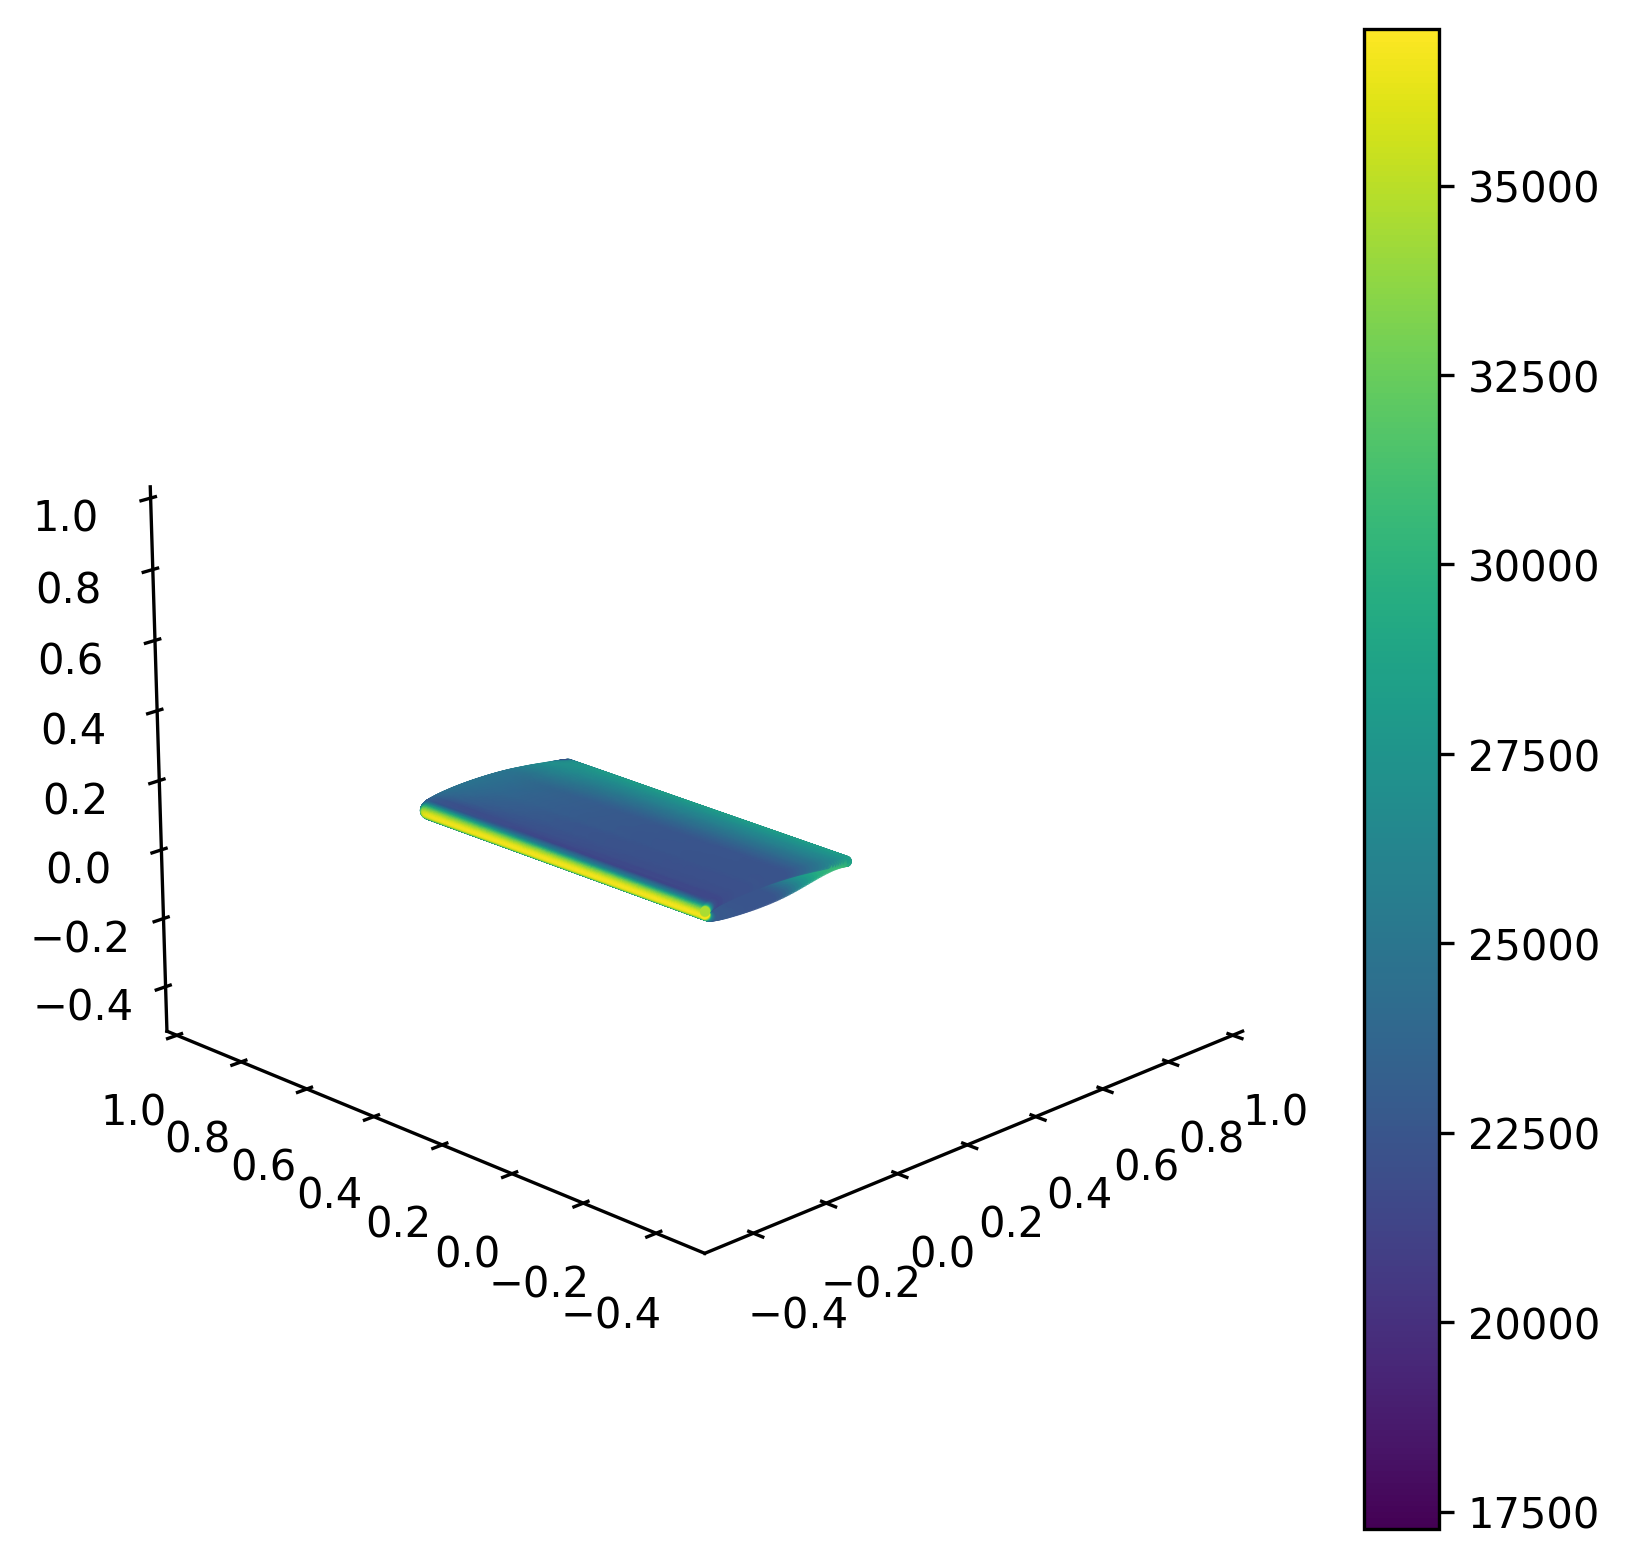

In [15]:
# We will now plot the mean flow
from mpl_toolkits.mplot3d import Axes3D

sizeseq = 2

fig = plt.figure(1, (5,5), dpi=300)
ax = Axes3D(fig)
ax.view_init(20, 225)

# We use the undeformed shape to plot pressure on it
undeformedx = []
undeformedy = []
undeformedz = []
for i in range(len(model.undeformedShape)):
    undeformedx.append(model.undeformedShape[i].ux)
    undeformedy.append(model.undeformedShape[i].uy)
    undeformedz.append(model.undeformedShape[i].uz)

# If we want to plot other modes, we only have to change the index in c = U[:,index]
# Remember the python convention: first element has index 0
p = ax.scatter(undeformedx, undeformedy, undeformedz, c = Xcenter, s=sizeseq)

# Set the grid limits
ax.axes.set_xlim3d(left=-0.5, right=1) 
ax.axes.set_ylim3d(bottom=-0.5, top=1) 
ax.axes.set_zlim3d(bottom=-0.5, top=1)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Introduce the colorbar
fig.colorbar(p)

plt.show()

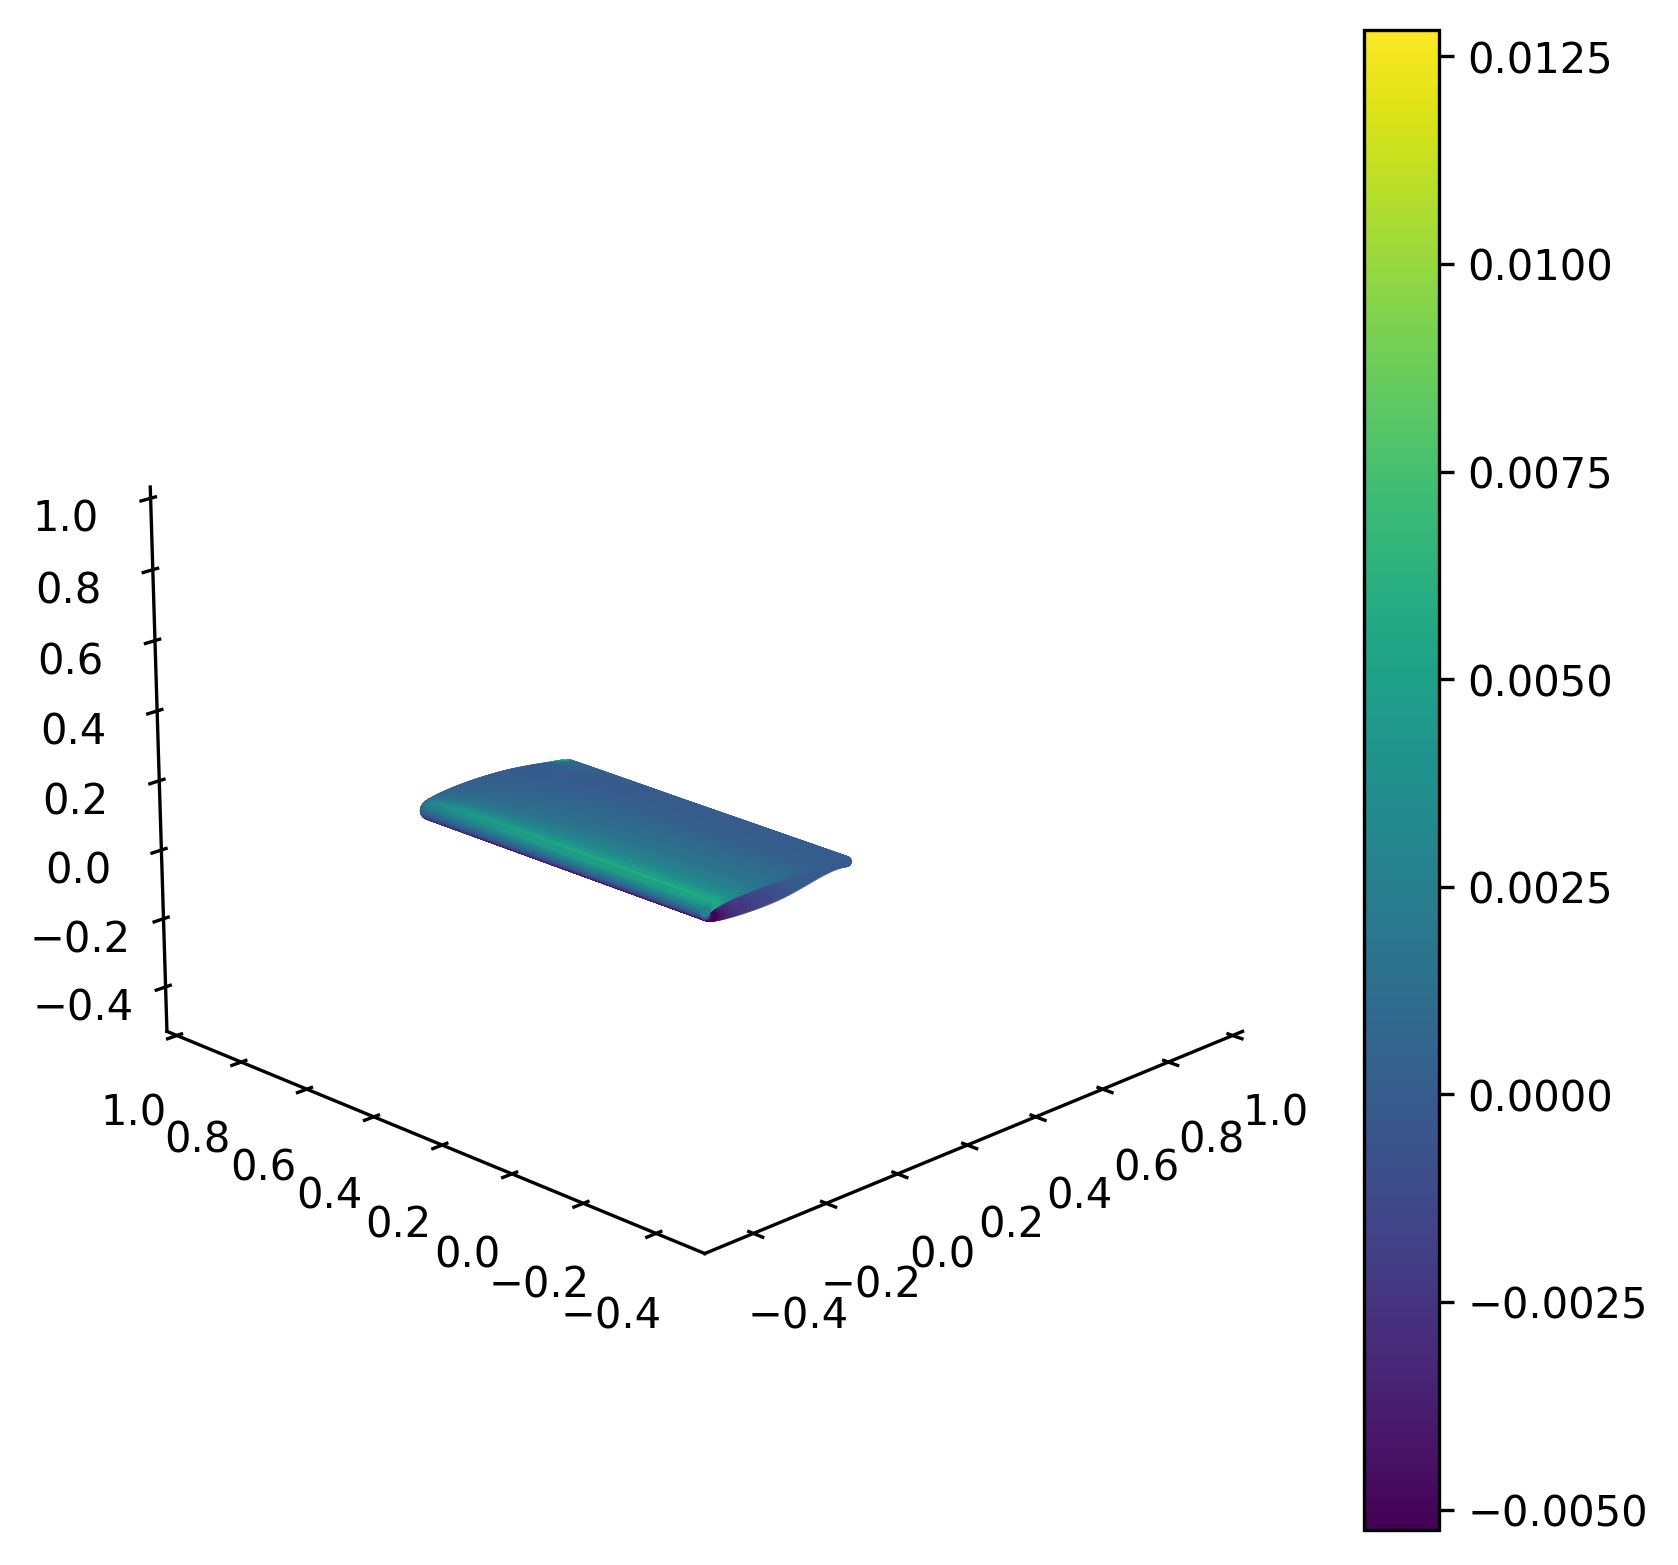

In [16]:
# We will now plot the first mode

sizeseq = 2

fig = plt.figure(1, (5,5), dpi=300)
ax = Axes3D(fig)
ax.view_init(20, 225)

# We use the undeformed shape to plot pressure on it
undeformedx = []
undeformedy = []
undeformedz = []
for i in range(len(model.undeformedShape)):
    undeformedx.append(model.undeformedShape[i].ux)
    undeformedy.append(model.undeformedShape[i].uy)
    undeformedz.append(model.undeformedShape[i].uz)

# If we want to plot other modes, we only have to change the index in c = U[:,index]
# Remember the python convention: first element has index 0
p = ax.scatter(undeformedx, undeformedy, undeformedz, c = Up[:,0], s=sizeseq)

# Set the grid limits
ax.axes.set_xlim3d(left=-0.5, right=1) 
ax.axes.set_ylim3d(bottom=-0.5, top=1) 
ax.axes.set_zlim3d(bottom=-0.5, top=1)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Introduce the colorbar
fig.colorbar(p)

plt.show()

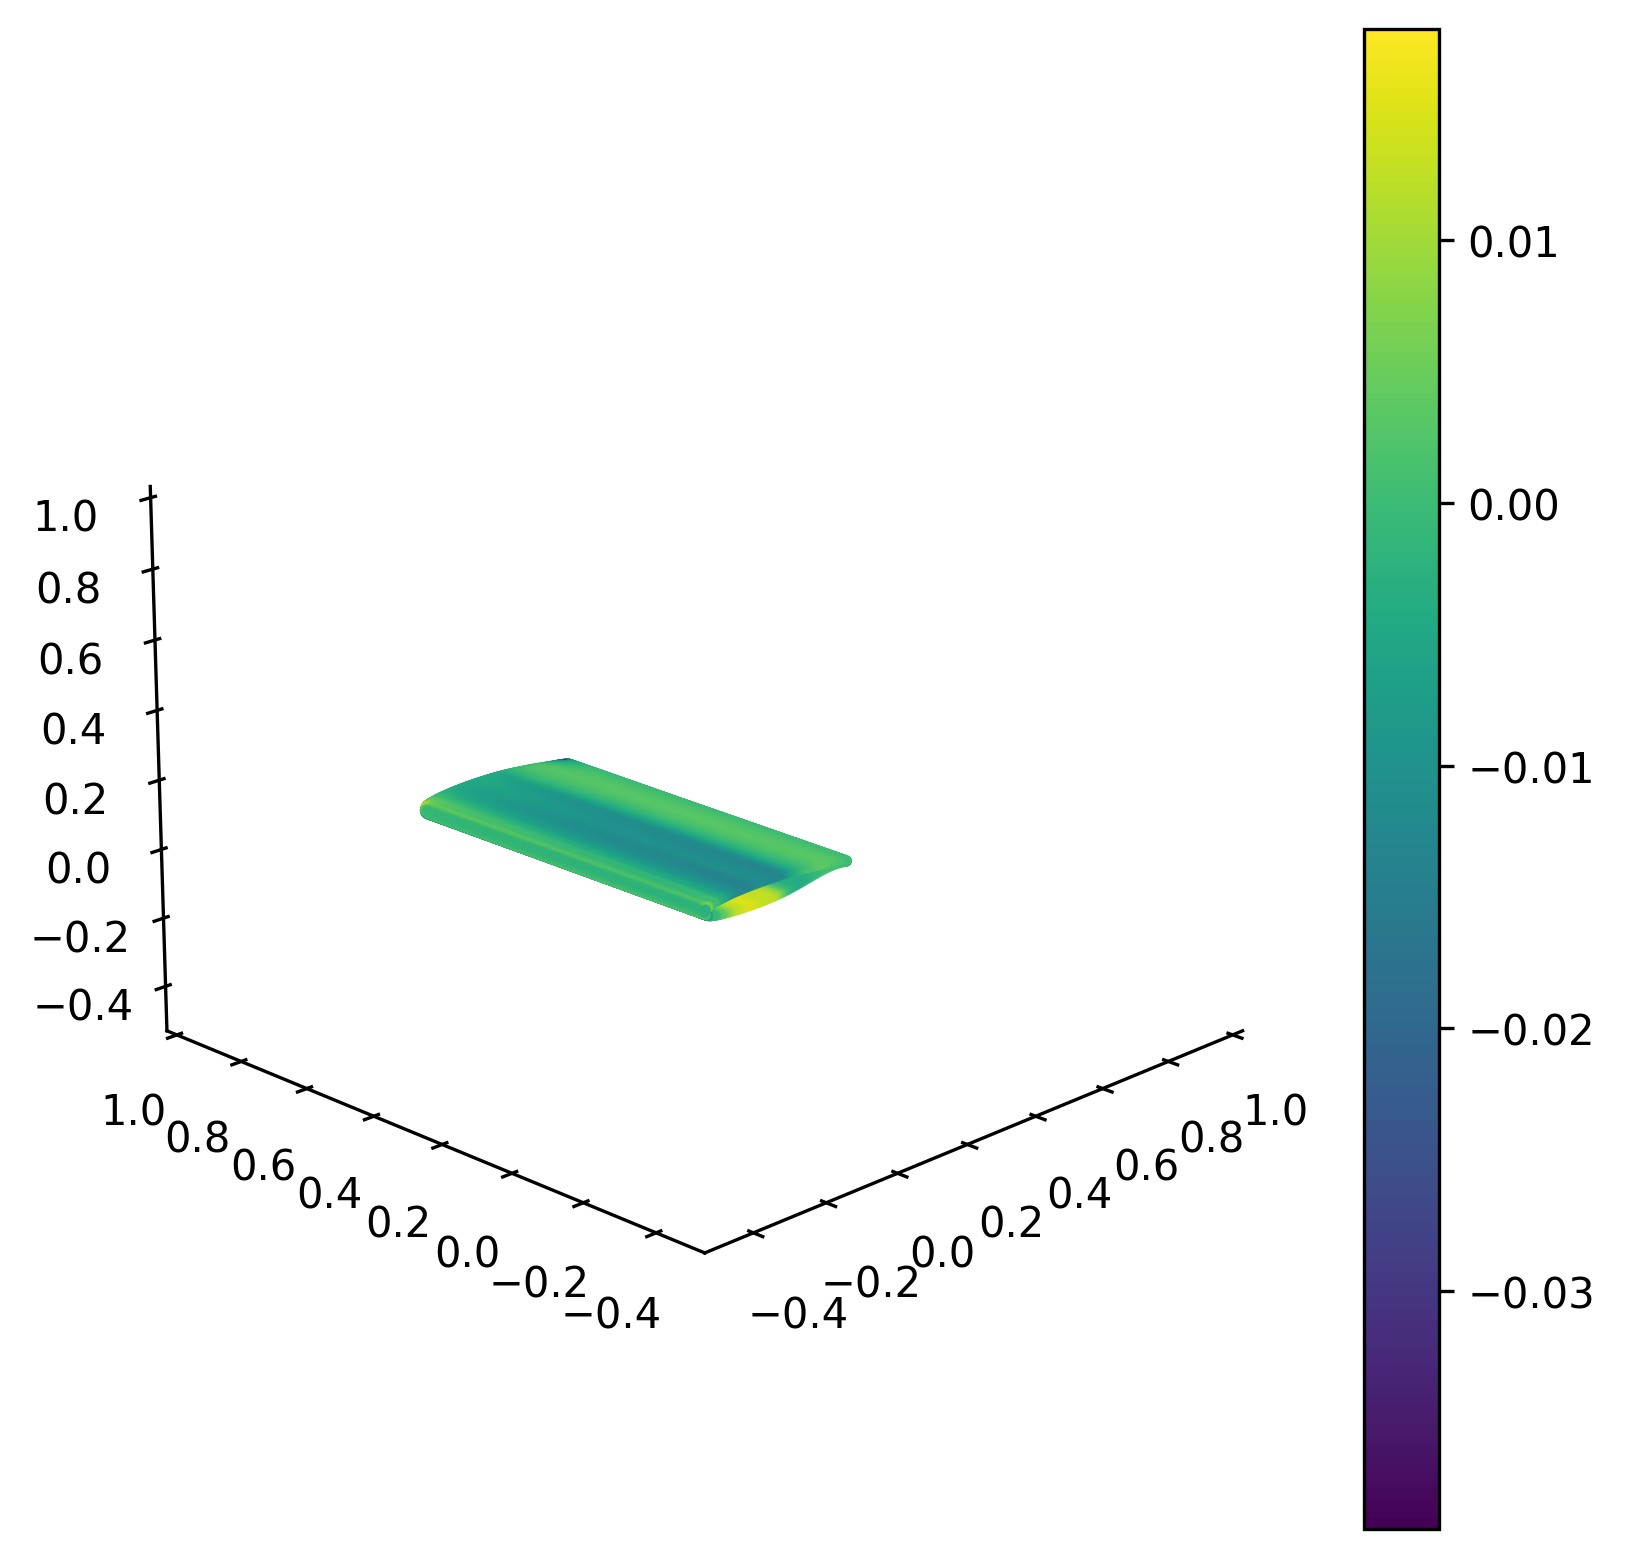

In [17]:
# We will now plot the second mode

sizeseq = 2

fig = plt.figure(1, (5,5), dpi=300)
ax = Axes3D(fig)
ax.view_init(20, 225)

# We use the undeformed shape to plot pressure on it
undeformedx = []
undeformedy = []
undeformedz = []
for i in range(len(model.undeformedShape)):
    undeformedx.append(model.undeformedShape[i].ux)
    undeformedy.append(model.undeformedShape[i].uy)
    undeformedz.append(model.undeformedShape[i].uz)

# If we want to plot other modes, we only have to change the index in c = U[:,index]
# Remember the python convention: first element has index 0
p = ax.scatter(undeformedx, undeformedy, undeformedz, c = -Up[:,1], s=sizeseq)

# Set the grid limits
ax.axes.set_xlim3d(left=-0.5, right=1) 
ax.axes.set_ylim3d(bottom=-0.5, top=1) 
ax.axes.set_zlim3d(bottom=-0.5, top=1)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Introduce the colorbar
fig.colorbar(p)

plt.show()